In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import wfdb
import ast

In [3]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [4]:
path = '/home/sebastian-cruz/Workspace/ECGLLM/physionet.org/files/ptb-xl/1.0.3/'
sampling_rate=100

In [7]:
# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
print(Y)

        patient_id    age  sex  height  weight  nurse  site      device  \
ecg_id                                                                    
1          15709.0   56.0    1     NaN    63.0    2.0   0.0   CS-12   E   
2          13243.0   19.0    0     NaN    70.0    2.0   0.0   CS-12   E   
3          20372.0   37.0    1     NaN    69.0    2.0   0.0   CS-12   E   
4          17014.0   24.0    0     NaN    82.0    2.0   0.0   CS-12   E   
5          17448.0   19.0    1     NaN    70.0    2.0   0.0   CS-12   E   
...            ...    ...  ...     ...     ...    ...   ...         ...   
21833      17180.0   67.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21834      20703.0  300.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21835      19311.0   59.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21836       8873.0   64.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21837      11744.0   68.0    0     NaN     NaN    1.0   2.0  AT-60    3   

             recording_d

In [8]:
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
print(Y)

        patient_id    age  sex  height  weight  nurse  site      device  \
ecg_id                                                                    
1          15709.0   56.0    1     NaN    63.0    2.0   0.0   CS-12   E   
2          13243.0   19.0    0     NaN    70.0    2.0   0.0   CS-12   E   
3          20372.0   37.0    1     NaN    69.0    2.0   0.0   CS-12   E   
4          17014.0   24.0    0     NaN    82.0    2.0   0.0   CS-12   E   
5          17448.0   19.0    1     NaN    70.0    2.0   0.0   CS-12   E   
...            ...    ...  ...     ...     ...    ...   ...         ...   
21833      17180.0   67.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21834      20703.0  300.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21835      19311.0   59.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21836       8873.0   64.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21837      11744.0   68.0    0     NaN     NaN    1.0   2.0  AT-60    3   

             recording_d

In [10]:
# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)
# print(X)

In [13]:
Xc = np.zeros_like(X)
for i in range(len(X)):
    for j in range(len(X[i])):
        # print(X[i][j])
        Xc[i][j] = np.fft.fft(X[i][j])
print(Xc)

/tmp/ipykernel_4389/814892823.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  Xc[i][j] = np.fft.fft(X[i][j])


[[[-3.55000000e-01 -8.46647182e-02 -2.95500000e-01 ... -1.66000000e-01
   -2.95500000e-01 -8.46647182e-02]
  [-3.45000000e-01 -7.22724134e-02 -2.78500000e-01 ... -1.76000000e-01
   -2.78500000e-01 -7.22724134e-02]
  [-3.16000000e-01 -6.67724134e-02 -2.67000000e-01 ... -2.17000000e-01
   -2.67000000e-01 -6.67724134e-02]
  ...
  [-1.02000000e-01 -1.69019238e-02  3.90000000e-02 ...  2.49000000e-01
    3.90000000e-02 -1.69019238e-02]
  [ 8.30000000e-02 -5.51313972e-02 -1.43000000e-01 ...  2.70000000e-01
   -1.43000000e-01 -5.51313972e-02]
  [-1.17000000e-01 -1.53061487e-01 -7.00000000e-02 ...  1.00000000e-03
   -7.00000000e-02 -1.53061487e-01]]

 [[ 7.46000000e-01  1.98232051e-01 -1.61500000e-01 ... -1.20000000e-02
   -1.61500000e-01  1.98232051e-01]
  [ 5.84000000e-01  1.50607695e-01 -1.59000000e-01 ... -7.60000000e-02
   -1.59000000e-01  1.50607695e-01]
  [ 3.54000000e-01  8.27968060e-02 -1.48000000e-01 ... -1.60000000e-01
   -1.48000000e-01  8.27968060e-02]
  ...
  [-4.98100000e+00  2.9

In [14]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [15]:
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass


In [1]:
print(Y)

NameError: name 'Y' is not defined

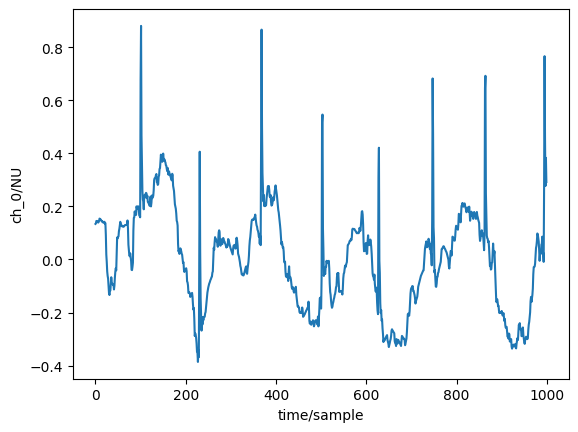

(21799, 1000, 12)

In [33]:
wfdb.plot_items(X[1,:,2])
X.shape

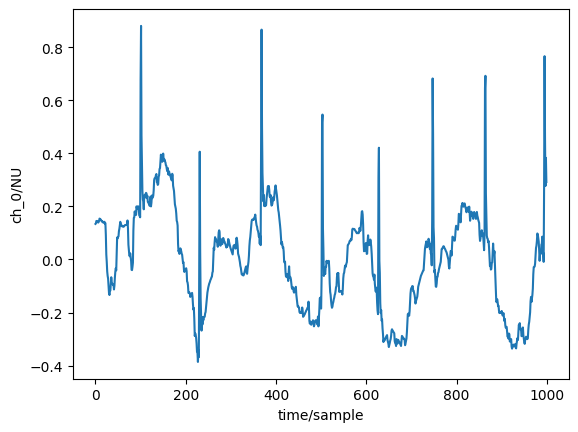

In [35]:
wfdb.plot_items(_X[1,2,:])

/tmp/ipykernel_101911/1149634422.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fft[i][j] = np.fft.fft(_X[i][j])


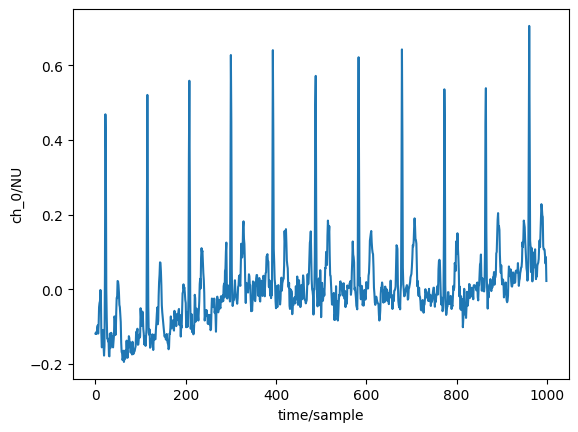

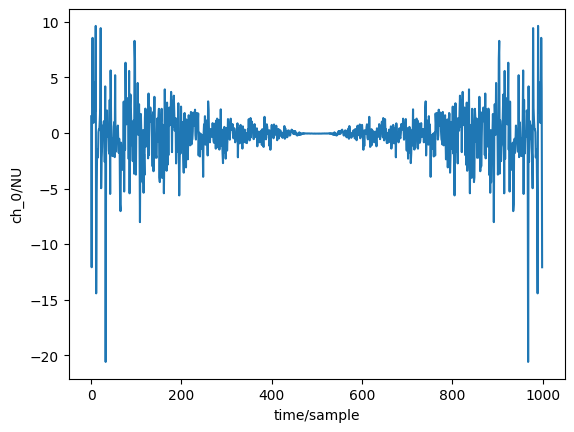

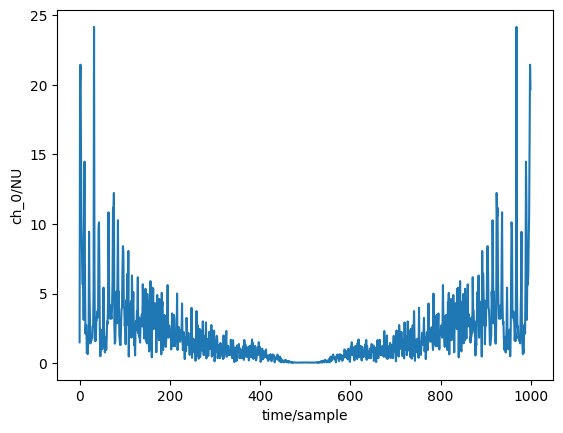

In [41]:
_X = np.transpose(X, (0,2,1))
X_fft = np.zeros_like(_X)
X_fftabs = np.zeros_like(_X)


for i in range(len(_X)):
    for j in range(len(_X[i])):
        X_fft[i][j] = np.fft.fft(_X[i][j])
        X_fftabs[i][j] = np.abs(np.fft.fft(_X[i][j]))

# wfdb.plot_items(X[0,:,0])
wfdb.plot_items(_X[0,0,:])
wfdb.plot_items(X_fft[0,0,:])
wfdb.plot_items(X_fftabs[0,0,:])

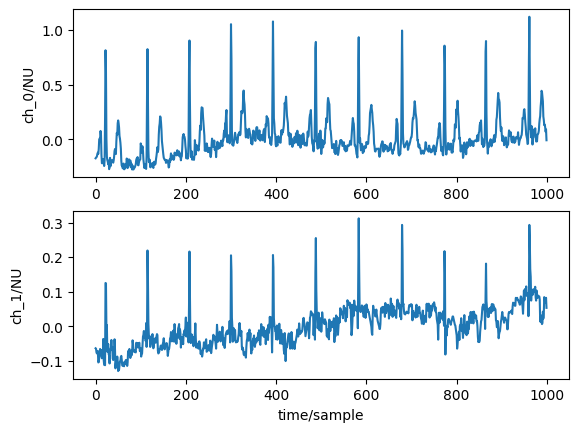

In [109]:
wfdb.plot_items(np.fft.fft(X[0,:,:2]))

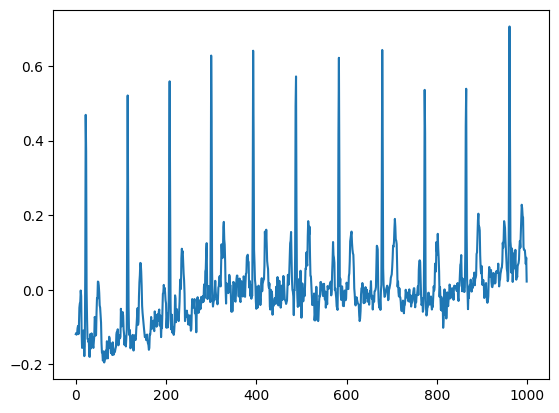

In [149]:
plt.plot(X[0,:,0])

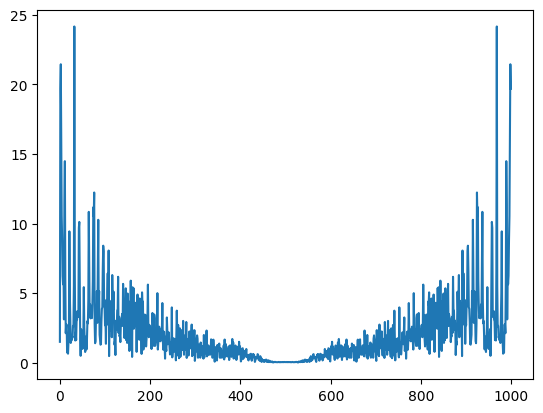

In [40]:
plt.plot(np.abs(np.fft.fft(X[0,:,0])))

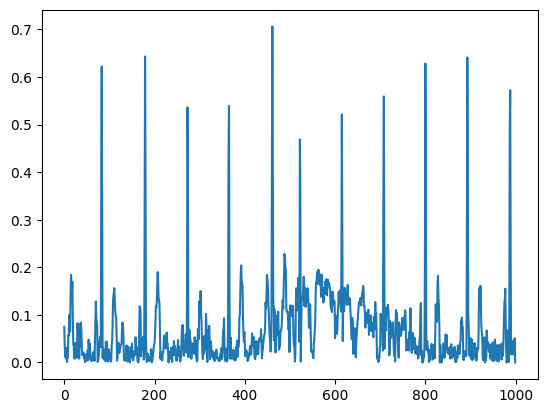

In [147]:
plt.plot(np.abs(np.fft.fftshift(X[0,:,0])))

In [150]:
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable


In [47]:
from scipy import signal
fs = 100
f0 = 50
Q = 30
# b_notch, a_notch = signal.iirnotch(f0, Q, fs=fs)

# #apply notch
# xnotch = signal.filtfilt(b_notch, a_notch, X[0,:,0])

# plt.plot(xnotch)

b_notch, a_notch = signal.iirnotch(f0, Q, sampling_rate)
X_notch = np.zeros_like(_X)

for i in range(len(_X)):
    for j in range(len(_X[i])):
        X_notch[i][j] = signal.filtfilt(b_notch, a_notch, _X[i][j])



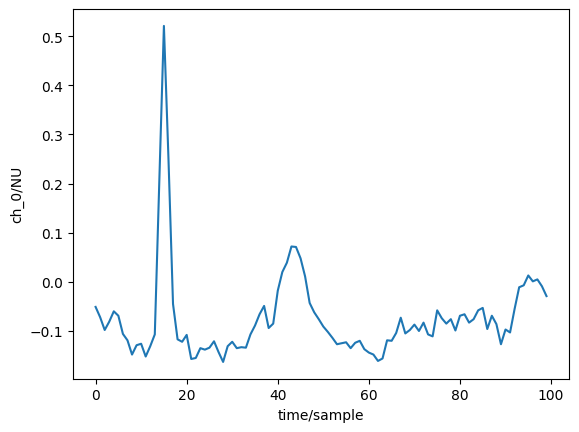

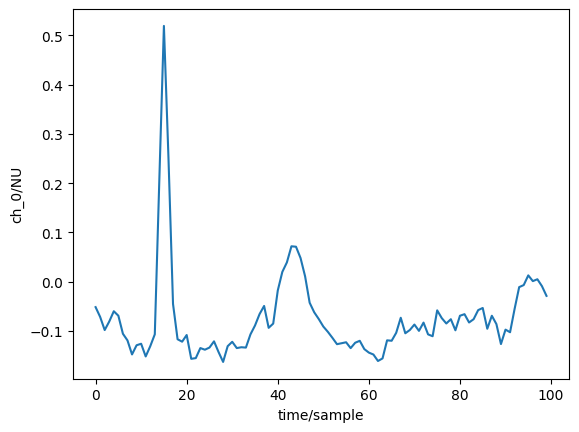

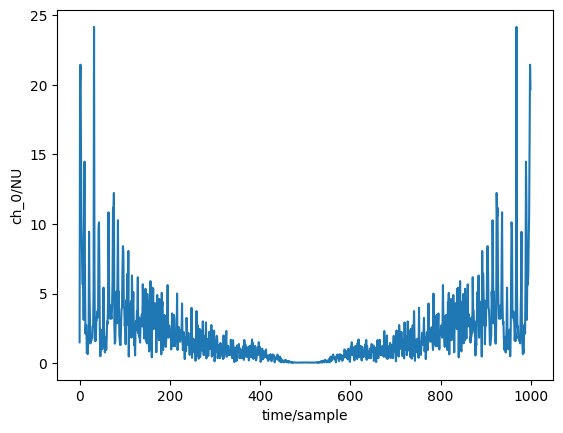

In [50]:
wfdb.plot_items(_X[0,0,100:200])
wfdb.plot_items(X_notch[0,0,100:200])
wfdb.plot_items(X_fftabs[0,0,:])
# _X[0,0,:].all() == X_notch[0,0,:].all()

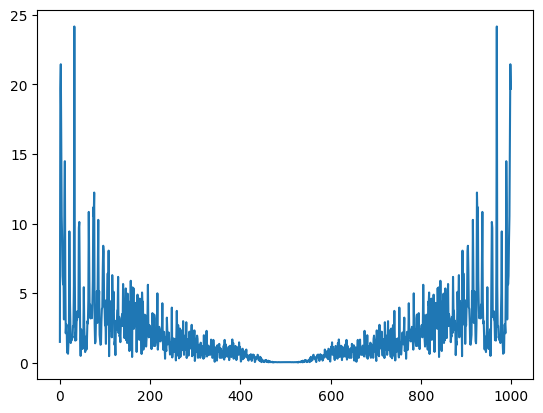

In [164]:
plt.plot(np.abs(np.fft.fft(xnotch)))

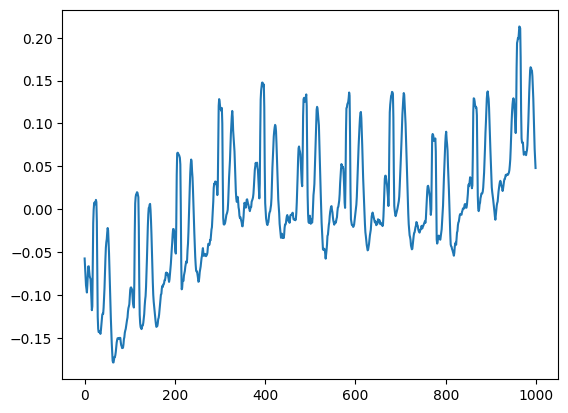

In [51]:
n = 10

#windows
ecg_window = np.convolve(X_notch[0,0,:], np.ones((n,))/n, mode='same')
plt.plot(ecg_window)

In [240]:
!pip install neurokit2 ts2vg PyWavelets

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 6.6 MB/s eta 0:00:0000:0100:010m


In [52]:
X_notch.shape

(21799, 12, 1000)

In [57]:
import neurokit2 as nk
signals, info = nk.ecg_process(X[0,:100,0], sampling_rate=100)
nk.ecg_plot(signals, info)

/home/sebastian-cruz/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sebastian-cruz/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/sebastian-cruz/.local/lib/python3.10/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


ValueError: The data length is too small to be segmented.

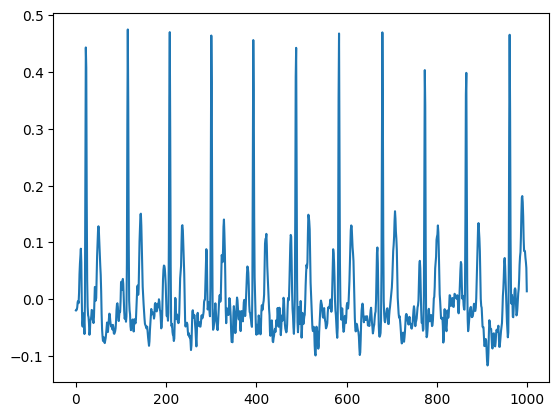

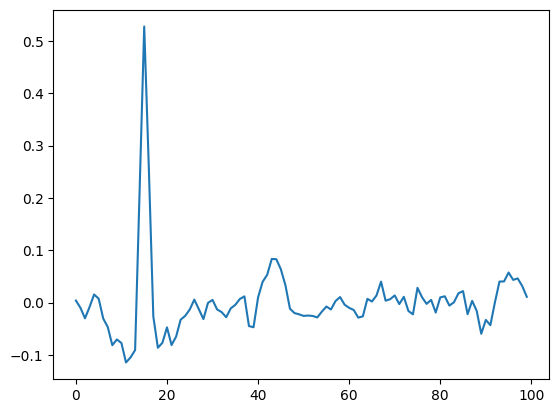

In [62]:
clean = signals['ECG_Clean']
cleaned = nk.ecg_clean(X[0,100:200,0], sampling_rate=100, method='emrich2023')
plt.plot(signals['ECG_Clean'])
plt.show()
plt.plot(cleaned)
plt.show()

In [200]:
# elgendi['ECG_R_Peaks'].shape

peaks = np.empty(X[0,:,0].shape)
peaks[:] = np.nan
for i in elgendi['ECG_R_Peaks']:
    peaks[i] = X[0,i,0]



{'method_peaks': 'emrich2023', 'method_fixpeaks': 'None', 'ECG_R_Peaks': array([22, 88]), 'sampling_rate': 100}


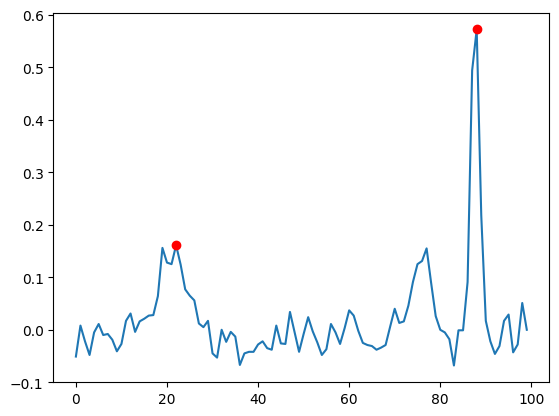

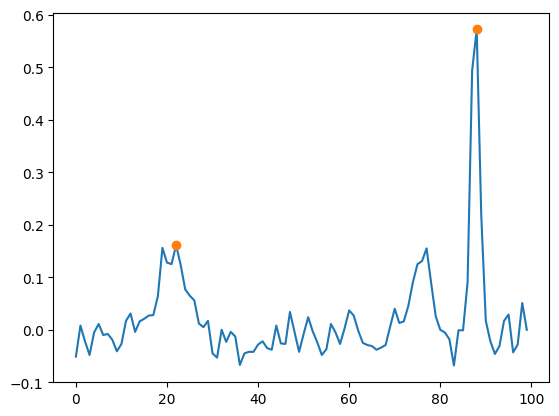

In [72]:
s, e = 400, 500
me = 'emrich2023'
cleaned = nk.ecg_clean(X[0,s:e,0], sampling_rate=100, method=me)
sign, elgendi = nk.ecg_peaks(cleaned, sampling_rate=100, method=me) 
print(elgendi)
peaks = np.empty(X[0,s:e,0].shape)
peaks[:] = np.nan
# for i in elgendi['ECG_R_Peaks']:
#     peaks[i] = X[0,i,0]
# plt.plot(X[0,s:e,0])
# plt.plot(peaks, 'o')
# plt.legend(['x','e'])
# plt.show()

plt.plot(X[0,s:e,0])
for i in elgendi['ECG_R_Peaks']:
    plt.plot(i, X[0,s:e,0][i], 'or')
plt.show()

plt.plot(X[0,s:e,0])
plt.plot(elgendi['ECG_R_Peaks'], [X[0,s:e,0][i] for i in elgendi['ECG_R_Peaks']], 'o')
# plt.scatter(elgendi['ECG_R_Peaks'], [X[0,:,0][i] for i in elgendi['ECG_R_Peaks']], color='red', label='Marcadores', zorder=5)
plt.show()